In [638]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from tensorflow import unique

from data.encoder import Encoder
import missingno as msno
from pytz import country_names
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from analyzer.stat_criterion.stat_criteria import StatCriteria
from analyzer.metric import MetricCalculator
from data.io import Reader, Saver
from data.plot import Drawer
import seaborn as sns
from analyzer.stat_criterion.analyser_timeseries_custom import AnalyserTimeSeriesCustom
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from statsmodels.tsa.api import VARMAX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Постановка задачи

Проанлизизоровать датасет, построить предсказание моделями либо ARIMA и ARIMAX либо SARIMA и SARIMAX

датасет: https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA210_Homework2_Railway.csv

# Выгрузка и проверка целостности датасета

In [639]:
pd.set_option("display.max_columns", 200)

df_original = pd.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA210_Homework2_Railway.csv", encoding='latin-1')
Saver.save_csv(df_original, "PDA210_practice2", False)
df_original.drop('Unnamed: 0', axis=1, inplace=True)
df = df_original.copy().reset_index(drop=True)

df.head(10)

Файл успешно сохранён: ./dataset/PDA210_practice2.csv


,time,x,y,direction,congestion
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
5,1991-04-01 00:00:00,0,1,SB,58
6,1991-04-01 00:00:00,0,1,WB,26
7,1991-04-01 00:00:00,0,2,EB,31
8,1991-04-01 00:00:00,0,2,NB,49
9,1991-04-01 00:00:00,0,2,SB,46


In [640]:
print("Уникальные временные метки:\n", df['time'].unique())

Уникальные временные метки:
 ['1991-04-01 00:00:00' '1991-04-01 00:20:00' '1991-04-01 00:40:00' ...
 '1991-07-27 13:20:00' '1991-07-27 13:40:00' '1991-07-27 14:00:00']


In [641]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548835 entries, 0 to 548834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        548835 non-null  object
 1   x           548835 non-null  int64 
 2   y           548835 non-null  int64 
 3   direction   548835 non-null  object
 4   congestion  548835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 20.9+ MB


In [642]:
# посмотрим на пропуски в данных
df.isna().sum()

time          0
x             0
y             0
direction     0
congestion    0
dtype: int64

<Axes: >

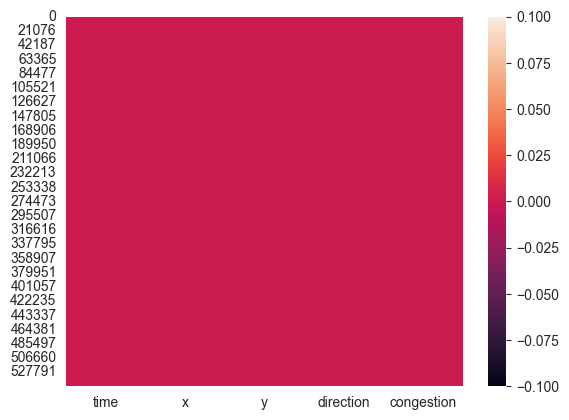

In [643]:
# Посмотрим на пропуски
sns.heatmap(df.sort_values(by='time').isna())

<Axes: >

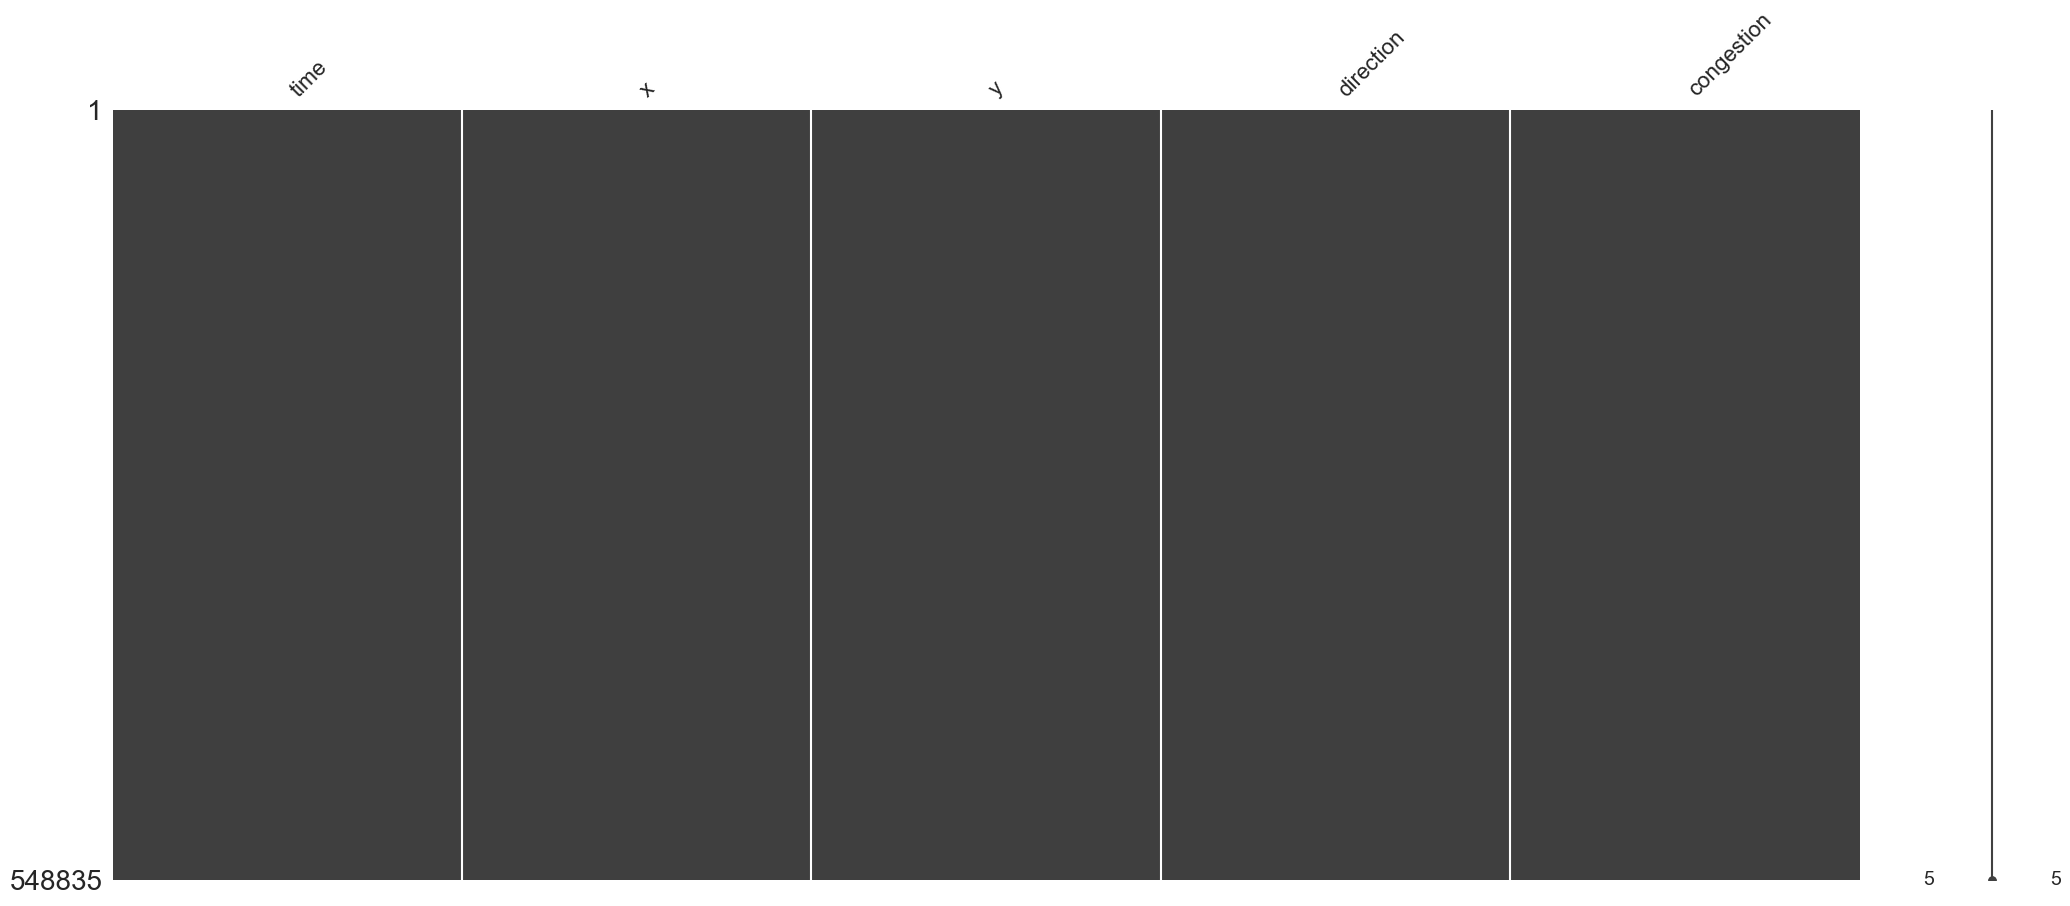

In [644]:
# Посмотрим на пропуски
msno.matrix(df)

## выявление неестественных значений

In [645]:
# Посмотрим статистику о датасете
df.describe()

,x,y,congestion
count,548835.000000,548835.000000,548835.000000
mean,1.138422,1.630767,47.749256
std,0.801476,1.089385,16.790760
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
max,2.000000,3.000000,100.000000


In [646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548835 entries, 0 to 548834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        548835 non-null  object
 1   x           548835 non-null  int64 
 2   y           548835 non-null  int64 
 3   direction   548835 non-null  object
 4   congestion  548835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 20.9+ MB


## оптимизация

In [647]:
df['distance'] = df.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2), axis=1)
df.drop(columns=['x', 'y'], inplace=True)

In [648]:
df['time'] = pd.to_datetime(df['time'])
df['distance'] = df['distance'].astype('float16')
df['congestion'] = df['congestion'].astype('uint8')

In [649]:
df['direction'].unique()

array(['EB', 'NB', 'SB', 'WB', 'NE', 'SW', 'NW', 'SE'], dtype=object)

In [650]:
most_common_direction = df['direction'].value_counts().idxmax()
print("Самое частое направление:", most_common_direction)

Самое частое направление: EB


In [651]:
mask = df['direction'] == 'EB'

df = df[mask]

df.drop(columns=['direction'], inplace=True)

In [652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101325 entries, 0 to 548834
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        101325 non-null  datetime64[ns]
 1   congestion  101325 non-null  uint8         
 2   distance    101325 non-null  float16       
dtypes: datetime64[ns](1), float16(1), uint8(1)
memory usage: 1.8 MB


## подготовка временного ряда

In [653]:
# Создаем полный 20-минутный временной диапазон
full_range = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='20min')

# Находим пропущенные временные метки
missing_times = full_range.difference(df['time'])
print("Пропущенные интервалы:\n", missing_times)

Пропущенные интервалы:
 DatetimeIndex(['1991-04-20 19:00:00', '1991-04-24 04:00:00',
               '1991-04-24 04:20:00', '1991-04-24 04:40:00',
               '1991-04-24 05:00:00', '1991-04-24 05:20:00',
               '1991-04-24 05:40:00', '1991-04-24 06:00:00',
               '1991-05-04 20:00:00', '1991-05-04 20:20:00',
               '1991-05-04 20:40:00', '1991-05-04 21:00:00',
               '1991-05-04 21:20:00', '1991-05-04 21:40:00',
               '1991-05-18 19:20:00', '1991-05-31 03:00:00',
               '1991-06-15 19:20:00', '1991-06-15 19:40:00',
               '1991-06-15 20:00:00', '1991-06-15 20:20:00',
               '1991-07-18 20:00:00', '1991-07-20 19:00:00',
               '1991-07-20 19:20:00'],
              dtype='datetime64[ns]', freq=None)


In [654]:
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

df = (
    df
    .resample('h')
    .mean()
)

In [655]:
target = ['congestion']
period = 24

In [656]:
df.head(10)

,congestion,distance
time,,
1991-04-01 00:00:00,42.666667,2.040202
1991-04-01 01:00:00,38.500000,2.040202
1991-04-01 02:00:00,42.361111,2.040202
1991-04-01 03:00:00,46.111111,2.040202
1991-04-01 04:00:00,40.805556,2.040202
1991-04-01 05:00:00,42.305556,2.040202
1991-04-01 06:00:00,45.638889,2.040202
1991-04-01 07:00:00,51.583333,2.040202
1991-04-01 08:00:00,53.166667,2.040202


In [657]:
print("Количество пропусков:", df[target].isna().sum())
print("Бесконечные значения:", np.isinf(df[target]).sum())

Количество пропусков: congestion    4
dtype: int64
Бесконечные значения: congestion    0
dtype: int64


In [658]:
df = df[target].fillna(df[target].interpolate())

In [659]:
print("Количество пропусков:", df[target].isna().sum())
print("Бесконечные значения:", np.isinf(df[target]).sum())

Количество пропусков: congestion    0
dtype: int64
Бесконечные значения: congestion    0
dtype: int64


# Первичный визуальный анализ зависимостей в данных


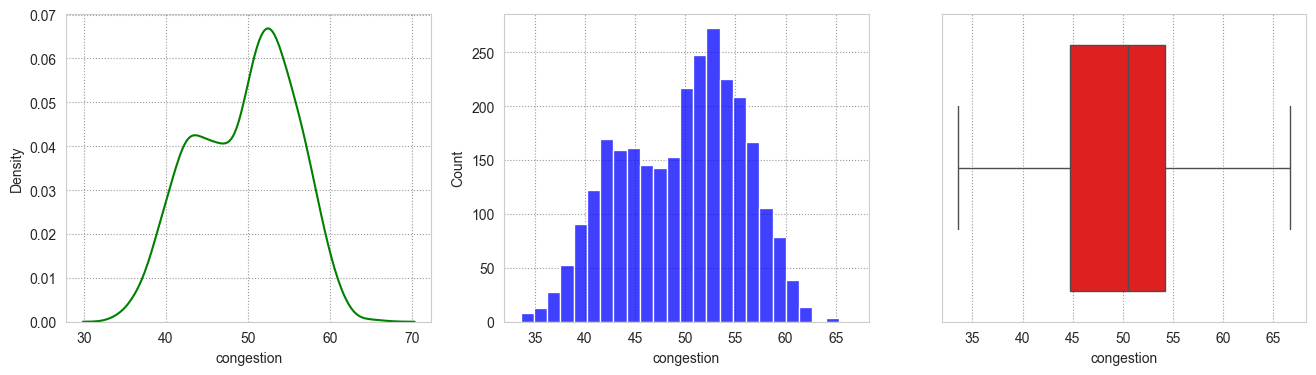

In [660]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

In [661]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

## проверка на стационарность

In [662]:
def test_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

test_stationarity(df[target])

p-value: 0.000
Ряд стационарен.


In [663]:
def test_kpss(series):
    result = kpss(series, regression='ct', nlags="auto")
    print(f"p-value: {result[1]:.3f}")

    if result[1] < 0.05:
        print("Ряд не стационарен.")
    else:
        print("Ряд стационарен.")

test_kpss(df[target])

p-value: 0.100
Ряд стационарен.


C:\Users\Tikhon\AppData\Local\Temp\ipykernel_240\3876179710.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='ct', nlags="auto")


## декомпозиция

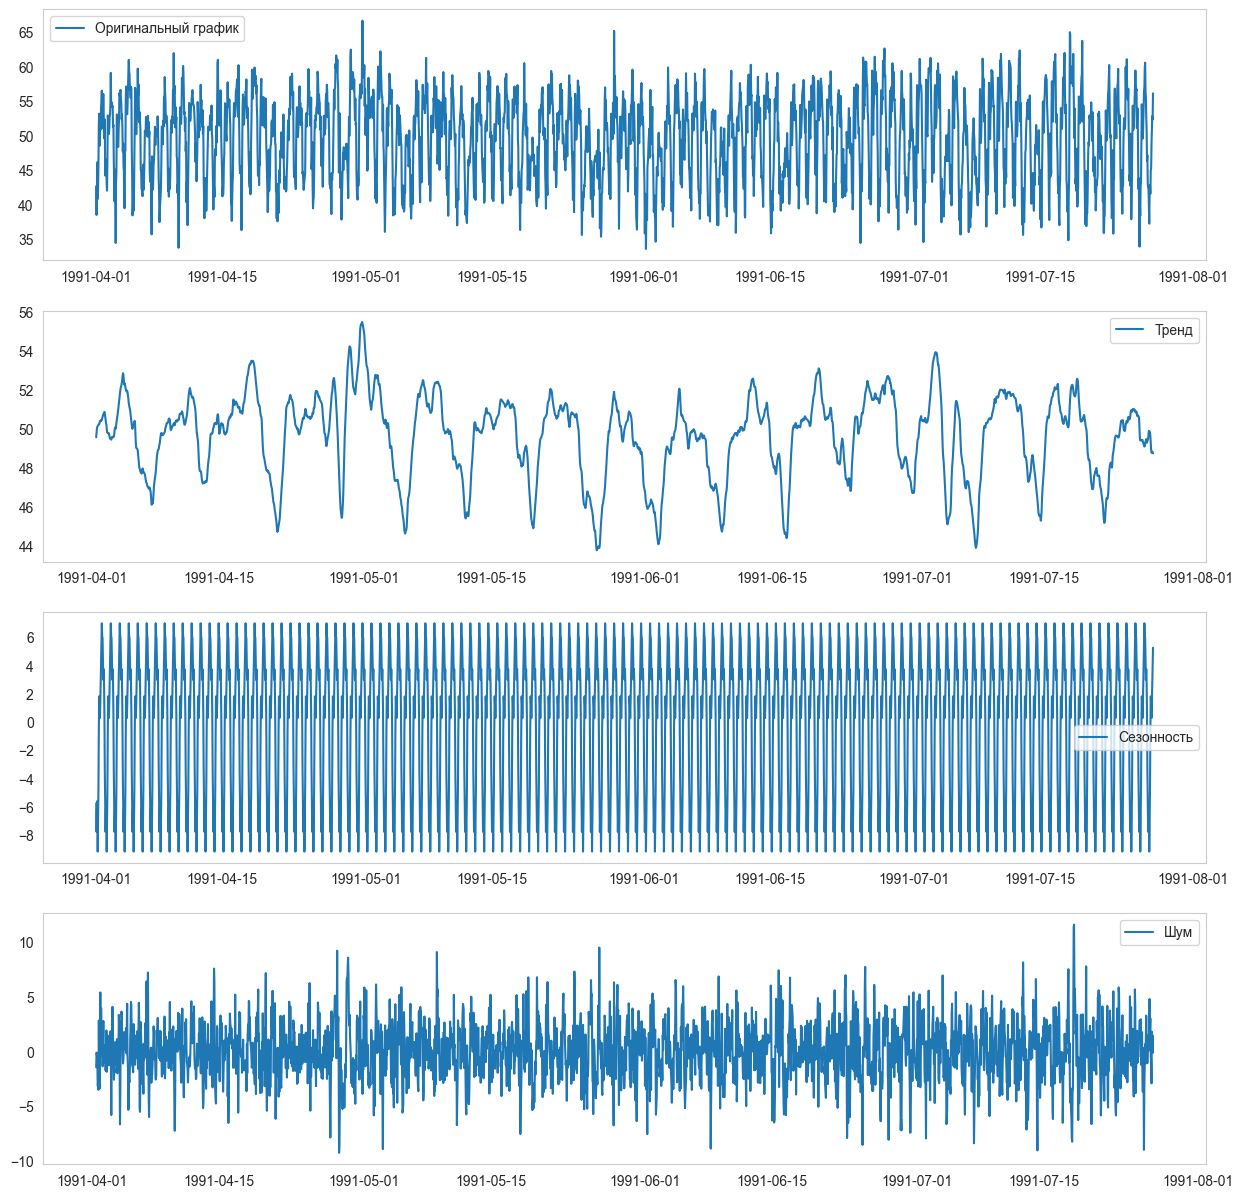

In [664]:
analysis = AnalyserTimeSeriesCustom(df[target])
analysis.decompositon(model='add', period=period)

## автокорреляционное разложение

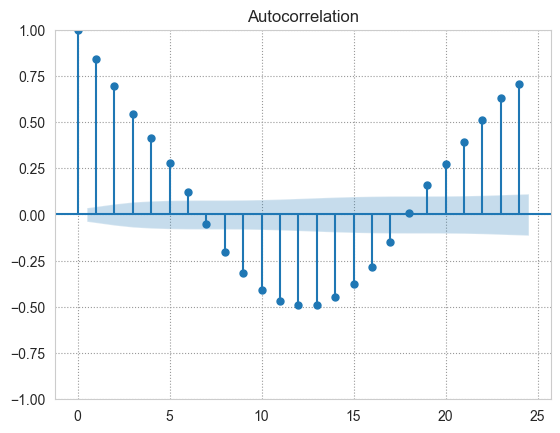

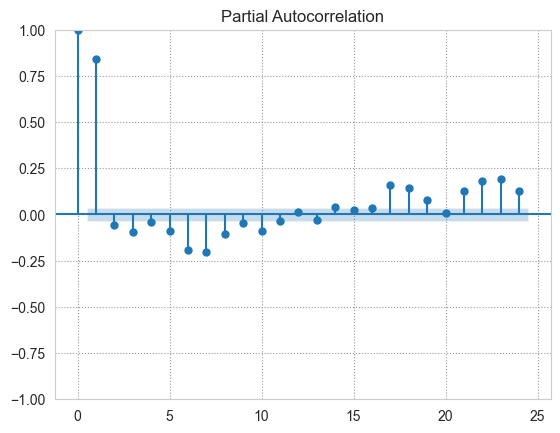

In [665]:
analysis.auto_correlation(period)

## подготовка данных для обучения

In [666]:
separate_point = int(len(df) * 0.75)

y_train = df[target][:separate_point]
y_test = df[target][separate_point:]

X_train = df.drop(columns=target)[:separate_point]
X_test = df.drop(columns=target)[separate_point:]

## модель SARIMAX

In [669]:
model = SARIMAX(
    y_train,
    order=(1,0,1),
    seasonal_order=(1,1,1,period)
)
results = model.fit(disp=False)

prediction = results.get_forecast(
    steps=len(y_test),
    exog=X_test[:len(y_test)] 
)
y_pred = prediction.predicted_mean

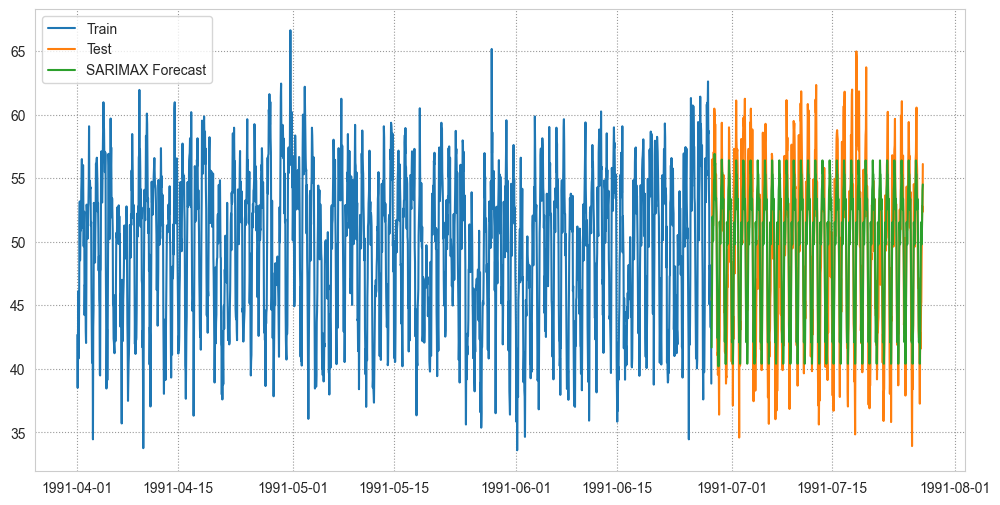

R²: 0.676
MAE: 2.95
MAPE: 0%
RMSE: 4
MSE: 14


In [670]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='SARIMAX Forecast')
plt.legend()
plt.show()

MetricCalculator.show_regression_metrics(y_test, y_pred)